In [478]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [479]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [480]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 40 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args

def concatenate_mini_batches_feat_orien(batch_result):
    mini_feat_batch_concat = []
    mini_orien_batch_concat = []
    
    for i, (boxs, mini_feat_batch, mini_orien_batch) in enumerate(batch_result):
        mini_feat_batch_concat.append(mini_feat_batch)
        mini_orien_batch_concat.append(mini_orien_batch)

    mini_feat_batch_concat = torch.cat(mini_feat_batch_concat, dim=0)
    mini_orien_batch_concat = torch.cat(mini_orien_batch_concat, dim=0)

    mini_dataloader = torch.stack([mini_feat_batch_concat, mini_orien_batch_concat], dim=1)

    return mini_dataloader


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.536601146062214
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

mini_dataloader  torch.Size([134, 2, 31, 31])


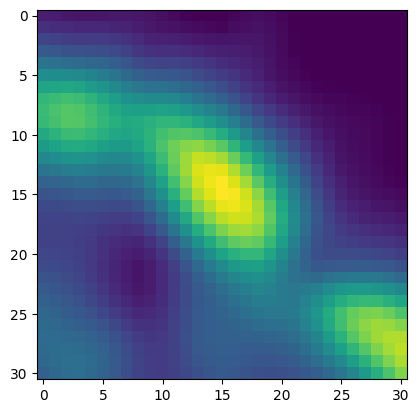

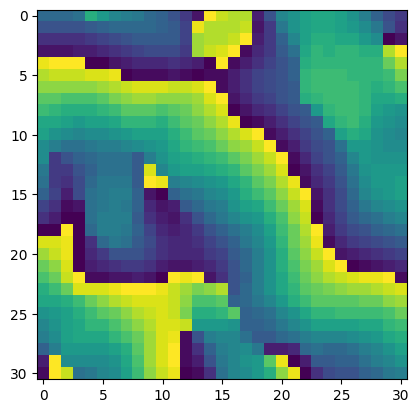

In [481]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

mini_dataloader = concatenate_mini_batches_feat_orien(batch_result)
print('mini_dataloader ',mini_dataloader.shape)

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [482]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 25

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.6
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


4
3


### Define arquitetura do modelo de rede siamesa

In [483]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

In [484]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)
        n_dim = X1.shape[-1]
        mask = enn.MaskModule(self.input_type, n_dim, margin=2).to(device)
        x = mask(x)
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 128)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        # Calculando a diferença entre os embeddings
        # diff = flatten_x1 - flatten_x2
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x


### Metodos para o processo de treinamento

In [485]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.8
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10)(x)
    return x


In [486]:
model =Siamesa(n_channel=2).to(device)
X1=torch.rand(8,2,31,31).to(device)
X2=torch.rand(8,2,31,31).to(device)
model(X1,X1)

tensor([0.9993, 0.9978, 0.9984, 0.9988, 0.9986, 0.9980, 0.9977, 0.9949],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [487]:
from torch.optim.lr_scheduler import ExponentialLR

def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        if (epoch % 15 == 0) and (epoch != 0):
            scheduler.step()
        print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=100,device=device)

Tests : 100%|██████████| 3/3 [00:00<00:00, 20.23it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 0, Train Loss: 0.7999, Test Loss: 0.7991


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.52it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 1, Train Loss: 0.7986, Test Loss: 0.7962


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.87it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 2, Train Loss: 0.7917, Test Loss: 0.7894


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.08it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 3, Train Loss: 0.7858, Test Loss: 0.7827


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.33it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 4, Train Loss: 0.7704, Test Loss: 0.7771


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.66it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 5, Train Loss: 0.7707, Test Loss: 0.7749


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.26it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 6, Train Loss: 0.7554, Test Loss: 0.7629


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.25it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 7, Train Loss: 0.7490, Test Loss: 0.7569


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.07it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 8, Train Loss: 0.7429, Test Loss: 0.7591


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.93it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 9, Train Loss: 0.7334, Test Loss: 0.7492


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.22it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 10, Train Loss: 0.7280, Test Loss: 0.7578


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.34it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 11, Train Loss: 0.7117, Test Loss: 0.7406


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.33it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 12, Train Loss: 0.7063, Test Loss: 0.7538


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.64it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 13, Train Loss: 0.7215, Test Loss: 0.7301


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.69it/s]



initial_lr  0.0001 lr  0.0001
Epoch: 14, Train Loss: 0.7009, Test Loss: 0.7297


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.54it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 15, Train Loss: 0.7002, Test Loss: 0.7411


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.91it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 16, Train Loss: 0.7214, Test Loss: 0.7336


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.58it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 17, Train Loss: 0.6871, Test Loss: 0.7261


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.41it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 18, Train Loss: 0.6885, Test Loss: 0.7195


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.01it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 19, Train Loss: 0.6831, Test Loss: 0.7204


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.77it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 20, Train Loss: 0.7040, Test Loss: 0.7201


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.13it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 21, Train Loss: 0.6665, Test Loss: 0.7196


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.43it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 22, Train Loss: 0.6599, Test Loss: 0.7149


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.49it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 23, Train Loss: 0.6756, Test Loss: 0.7152


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.13it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 24, Train Loss: 0.6802, Test Loss: 0.6919


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.84it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 25, Train Loss: 0.6692, Test Loss: 0.7050


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.16it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 26, Train Loss: 0.6616, Test Loss: 0.7044


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.26it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 27, Train Loss: 0.6653, Test Loss: 0.6961


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.77it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 28, Train Loss: 0.6740, Test Loss: 0.7199


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.93it/s]



initial_lr  0.0001 lr  7.500000000000001e-05
Epoch: 29, Train Loss: 0.6225, Test Loss: 0.7053


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.52it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 30, Train Loss: 0.6648, Test Loss: 0.6973


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.97it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 31, Train Loss: 0.6504, Test Loss: 0.6965


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.97it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 32, Train Loss: 0.6391, Test Loss: 0.6926


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.01it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 33, Train Loss: 0.6471, Test Loss: 0.6793


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.94it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 34, Train Loss: 0.6228, Test Loss: 0.6977


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.28it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 35, Train Loss: 0.6323, Test Loss: 0.6781


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.48it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 36, Train Loss: 0.6728, Test Loss: 0.6900


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.61it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 37, Train Loss: 0.6328, Test Loss: 0.7005


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.06it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 38, Train Loss: 0.6456, Test Loss: 0.6760


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.65it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 39, Train Loss: 0.6248, Test Loss: 0.6669


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.28it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 40, Train Loss: 0.6353, Test Loss: 0.6864


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.47it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 41, Train Loss: 0.6611, Test Loss: 0.6856


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.00it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 42, Train Loss: 0.6260, Test Loss: 0.6930


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.49it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 43, Train Loss: 0.6372, Test Loss: 0.6840


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.97it/s]



initial_lr  0.0001 lr  5.6250000000000005e-05
Epoch: 44, Train Loss: 0.6586, Test Loss: 0.6887


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.24it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 45, Train Loss: 0.6105, Test Loss: 0.6857


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.76it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 46, Train Loss: 0.6007, Test Loss: 0.6771


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.24it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 47, Train Loss: 0.6359, Test Loss: 0.7000


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.24it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 48, Train Loss: 0.5890, Test Loss: 0.6910


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.26it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 49, Train Loss: 0.6139, Test Loss: 0.6653


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.54it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 50, Train Loss: 0.6169, Test Loss: 0.6694


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.29it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 51, Train Loss: 0.6042, Test Loss: 0.6612


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.64it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 52, Train Loss: 0.6275, Test Loss: 0.7001


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.71it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 53, Train Loss: 0.6431, Test Loss: 0.6866


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.15it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 54, Train Loss: 0.6202, Test Loss: 0.6865


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.44it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 55, Train Loss: 0.6093, Test Loss: 0.6669


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.79it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 56, Train Loss: 0.6186, Test Loss: 0.6754


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.88it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 57, Train Loss: 0.5900, Test Loss: 0.6784


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.26it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 58, Train Loss: 0.5944, Test Loss: 0.6711


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.61it/s]



initial_lr  0.0001 lr  4.21875e-05
Epoch: 59, Train Loss: 0.6384, Test Loss: 0.6900


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.90it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 60, Train Loss: 0.5923, Test Loss: 0.6982


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.50it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 61, Train Loss: 0.5856, Test Loss: 0.6674


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.61it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 62, Train Loss: 0.5895, Test Loss: 0.6430


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.04it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 63, Train Loss: 0.6124, Test Loss: 0.6831


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.83it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 64, Train Loss: 0.6240, Test Loss: 0.6921


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.75it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 65, Train Loss: 0.6365, Test Loss: 0.6687


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.26it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 66, Train Loss: 0.5865, Test Loss: 0.6454


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.10it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 67, Train Loss: 0.6167, Test Loss: 0.6866


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.65it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 68, Train Loss: 0.6012, Test Loss: 0.6582


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.75it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 69, Train Loss: 0.5858, Test Loss: 0.6707


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.71it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 70, Train Loss: 0.5894, Test Loss: 0.6618


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.95it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 71, Train Loss: 0.6112, Test Loss: 0.6588


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.42it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 72, Train Loss: 0.5971, Test Loss: 0.6578


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.85it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 73, Train Loss: 0.6115, Test Loss: 0.6665


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.32it/s]



initial_lr  0.0001 lr  3.1640625e-05
Epoch: 74, Train Loss: 0.5963, Test Loss: 0.6584


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.99it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 75, Train Loss: 0.5933, Test Loss: 0.6637


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.90it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 76, Train Loss: 0.5937, Test Loss: 0.6621


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.84it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 77, Train Loss: 0.6006, Test Loss: 0.6565


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.32it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 78, Train Loss: 0.6112, Test Loss: 0.6669


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.09it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 79, Train Loss: 0.5784, Test Loss: 0.6568


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.23it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 80, Train Loss: 0.5882, Test Loss: 0.6614


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.97it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 81, Train Loss: 0.5652, Test Loss: 0.6557


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.90it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 82, Train Loss: 0.6162, Test Loss: 0.6624


Tests : 100%|██████████| 3/3 [00:00<00:00, 23.90it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 83, Train Loss: 0.6039, Test Loss: 0.6470


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.21it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 84, Train Loss: 0.5935, Test Loss: 0.6628


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.25it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 85, Train Loss: 0.6063, Test Loss: 0.6562


Tests : 100%|██████████| 3/3 [00:00<00:00, 25.27it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 86, Train Loss: 0.5968, Test Loss: 0.6708


Tests : 100%|██████████| 3/3 [00:00<00:00, 18.97it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 87, Train Loss: 0.6240, Test Loss: 0.6728


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.53it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 88, Train Loss: 0.6207, Test Loss: 0.6879


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.14it/s]



initial_lr  0.0001 lr  2.373046875e-05
Epoch: 89, Train Loss: 0.5865, Test Loss: 0.6862


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.46it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 90, Train Loss: 0.5814, Test Loss: 0.6620


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.59it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 91, Train Loss: 0.5914, Test Loss: 0.6373


Tests : 100%|██████████| 3/3 [00:00<00:00, 22.14it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 92, Train Loss: 0.6039, Test Loss: 0.6660


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.69it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 93, Train Loss: 0.6052, Test Loss: 0.6615


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.20it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 94, Train Loss: 0.6046, Test Loss: 0.6684


Tests : 100%|██████████| 3/3 [00:00<00:00, 19.16it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 95, Train Loss: 0.6187, Test Loss: 0.6675


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.56it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 96, Train Loss: 0.6050, Test Loss: 0.6902


Tests : 100%|██████████| 3/3 [00:00<00:00, 21.88it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 97, Train Loss: 0.5962, Test Loss: 0.6627


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.94it/s]



initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 98, Train Loss: 0.6112, Test Loss: 0.6638


Tests : 100%|██████████| 3/3 [00:00<00:00, 20.69it/s]


initial_lr  0.0001 lr  1.7797851562499998e-05
Epoch: 99, Train Loss: 0.5945, Test Loss: 0.6628


### Teste com a rede siamesa

In [488]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [489]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


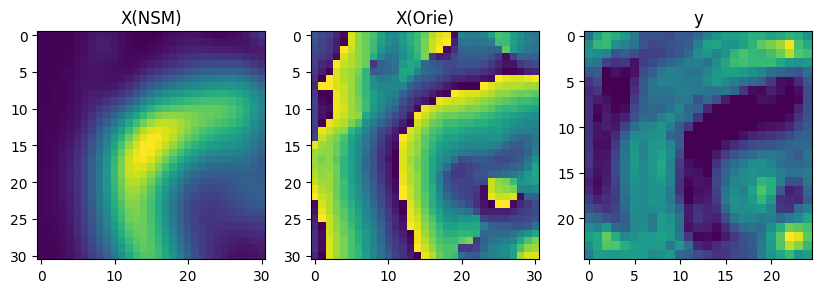

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1385, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1705, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2433, device='cuda:0') tensor(0.8384, device='cuda:0')


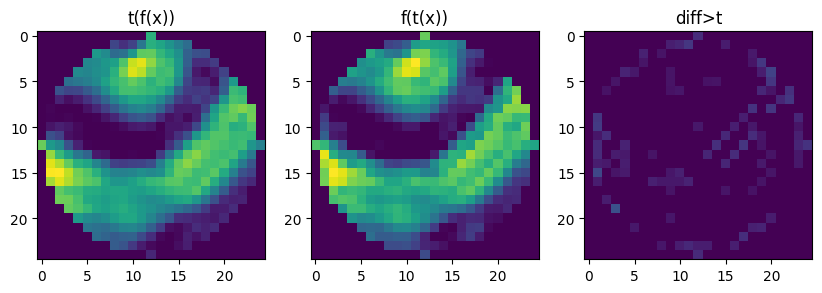

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1147, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1129, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1952, device='cuda:0') tensor(0.8123, device='cuda:0')


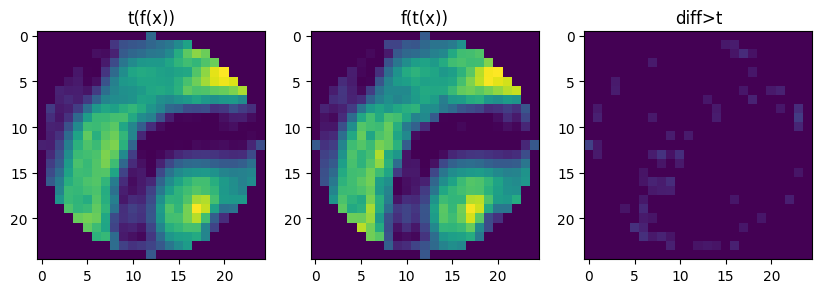

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1267, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1324, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1520, device='cuda:0') tensor(0.7708, device='cuda:0')


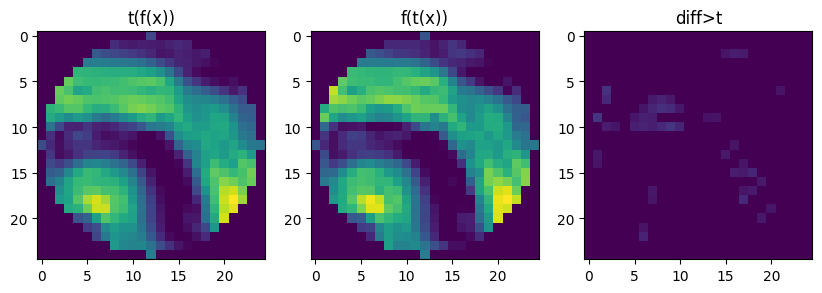

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1091, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.2118, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2205, device='cuda:0') tensor(0.8871, device='cuda:0')


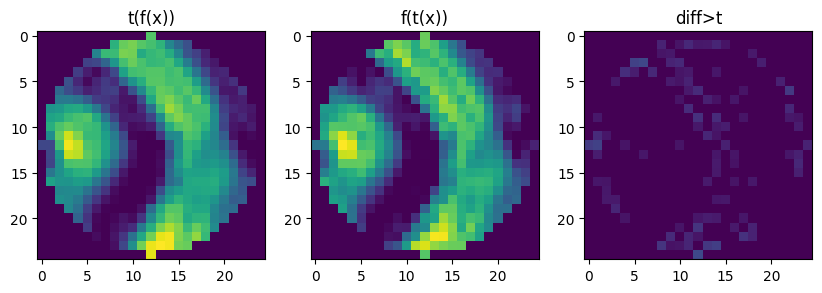

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1268, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0510, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2935, device='cuda:0') tensor(0.8569, device='cuda:0')


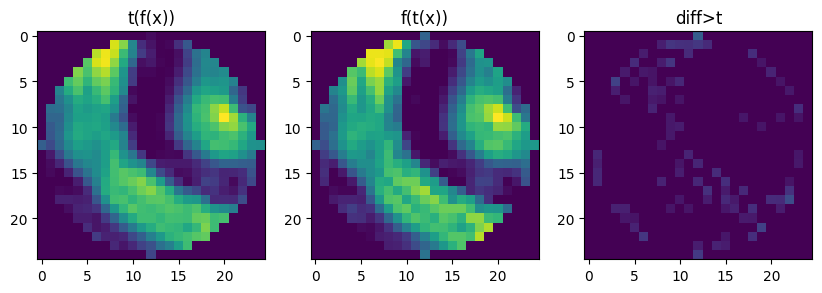

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1268, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0510, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2935, device='cuda:0') tensor(0.8569, device='cuda:0')


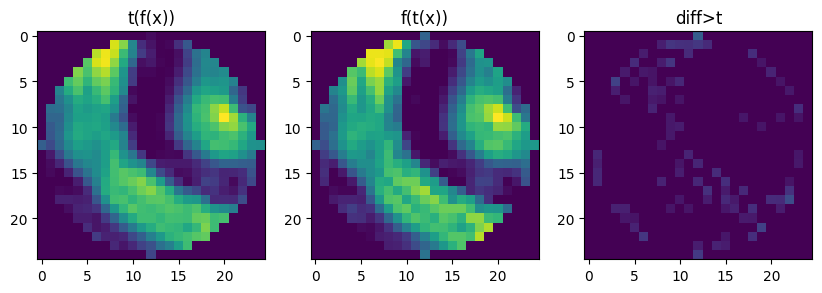

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1391, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1618, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1650, device='cuda:0') tensor(0.8191, device='cuda:0')


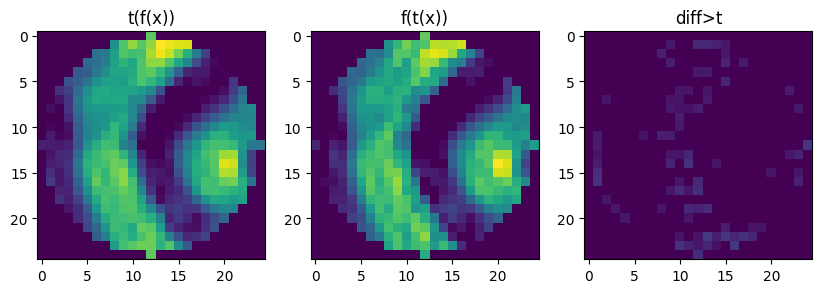

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1428, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1422, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1980, device='cuda:0') tensor(0.8407, device='cuda:0')


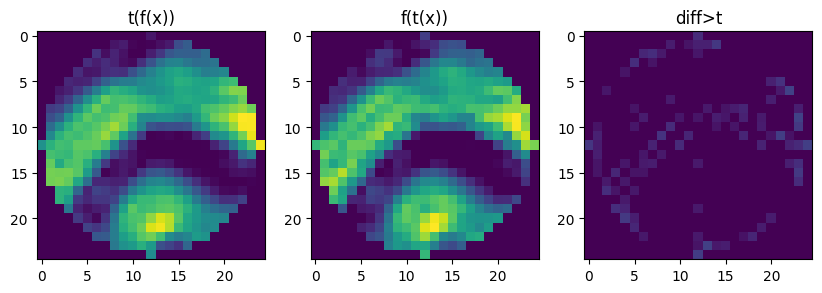

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1192, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.2838, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2217, device='cuda:0') tensor(0.8855, device='cuda:0')


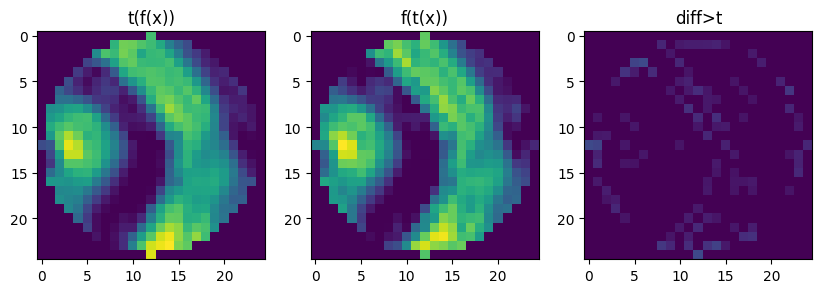

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1260, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.1935, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2226, device='cuda:0') tensor(0.8273, device='cuda:0')


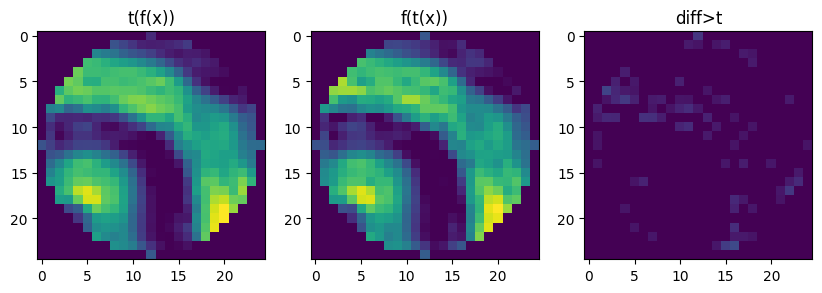

In [490]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)



iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[index,0])
        y2n=normalize_tensor(y_rotated2[index,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [491]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

def matching_single_points(data1, data2, apply_random_transform=False):
    size = len(data1)
    matches = []

    with torch.no_grad():
        for i in range(len(data2)):
            img_temp = data2[i][None]

            if apply_random_transform:
                img_temp2 = random_transform(img_temp)
            else:
                img_temp2 = img_temp.clone()

            data_temp = copy_tensor(img_temp2, size)
            if apply_random_transform:
                data_temp = random_transform(data_temp)

            distances = model(data1, data_temp)
            match_index = distances.argmin().item()
            matches.append((i, match_index))
    print(matches)
    return np.array(matches)

            

matching_results = matching_single_points(data, data, apply_random_transform=True)
print('matching pair ',matching_results)


# for (i,j) in matching_results[:10]:
#     print('i ',i,' j ',j)
#     plot_pair_image(data[i,0],data2[j,0],'feat_a {}'.format(i),'feat_b {}'.format(j))

[(0, 0), (1, 5), (2, 4), (3, 3), (4, 1), (5, 1), (6, 12), (7, 14), (8, 6), (9, 10), (10, 2), (11, 11), (12, 4), (13, 13), (14, 1), (15, 15), (16, 16), (17, 20), (18, 19), (19, 12), (20, 20), (21, 21), (22, 7), (23, 23), (24, 24)]
matching pair  [[ 0  0]
 [ 1  5]
 [ 2  4]
 [ 3  3]
 [ 4  1]
 [ 5  1]
 [ 6 12]
 [ 7 14]
 [ 8  6]
 [ 9 10]
 [10  2]
 [11 11]
 [12  4]
 [13 13]
 [14  1]
 [15 15]
 [16 16]
 [17 20]
 [18 19]
 [19 12]
 [20 20]
 [21 21]
 [22  7]
 [23 23]
 [24 24]]


### Comparar features de duas imagens



In [492]:
#plot pair image with tensor
def plot_pair_image(data1, data2, title1, title2):
    # vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(data1.cpu().detach())
    ax[0].set_title(title1)
    ax[1].imshow(data2.cpu().detach())
    ax[1].set_title(title2)
    plt.show()

In [493]:
def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()


def plot_matches_by_coord(image1, coords1, image2, coords2, matches, **kwargs):
    import numpy as np
    import matplotlib.pyplot as plt

    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image, cmap='gray')
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]
    ax.plot(coords1[0, :], coords1[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)
    ax.plot(coords2[0, :] + offset, coords2[1, :], 'o',
            markerfacecolor='none', markeredgecolor='r',
            markersize=20, markeredgewidth=1)

    for i, (x, y) in enumerate(zip(coords1[0, :], coords1[1, :])):
        ax.annotate(str(i), (x, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for i, (x, y) in enumerate(zip(coords2[0, :], coords2[1, :])):
        ax.annotate(str(i), (x + offset, y),
                    textcoords="offset points", xytext=(0, 10),
                    color='red', ha='center', fontsize=13)

    for match in matches:
        x1, y1 = coords1[0, match[0]], coords1[1, match[0]]
        x2, y2 = coords2[0, match[1]] + offset, coords2[1, match[1]]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

In [494]:
#exibe duas imagens lado a lado com matplotlib com dois titulos
def imshow2(img1,img2,coords=None,t1="0",t2="1",figsize=(15,10)):
    fig = plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(img1)
    ax1.title.set_text(t1)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img2)
    ax2.title.set_text(t2)
    if coords is not None:
        ax1.plot(coords[0,:],coords[1,:], 'r+')
        ax2.plot(coords[0,:],coords[1,:], 'r+')
        # zip joins x and y coordinates in pairs
        labels = np.arange(coords.shape[1])
        for i, (x,y) in enumerate(zip(coords[0,:],coords[1,:])):
            ax1.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
            
            ax2.annotate(labels[i], # this is the text
                (x,y), # these are the coordinates to position the label
                textcoords="offset points", # how to position the text
                xytext=(0,10), # distance from text to points (x,y)
                color='white',
                ha='center') # horizontal alignment can be left, right or center
    plt.show()

15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
1 tensor([0])


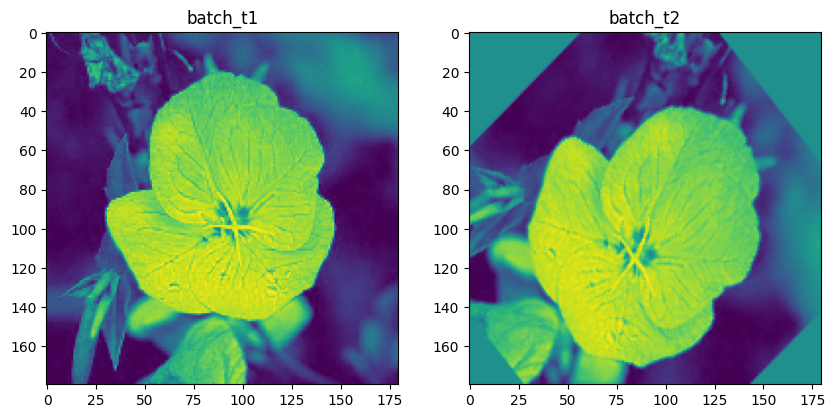

mini_dataloader  torch.Size([10, 2, 31, 31]) torch.Size([1, 3, 10])


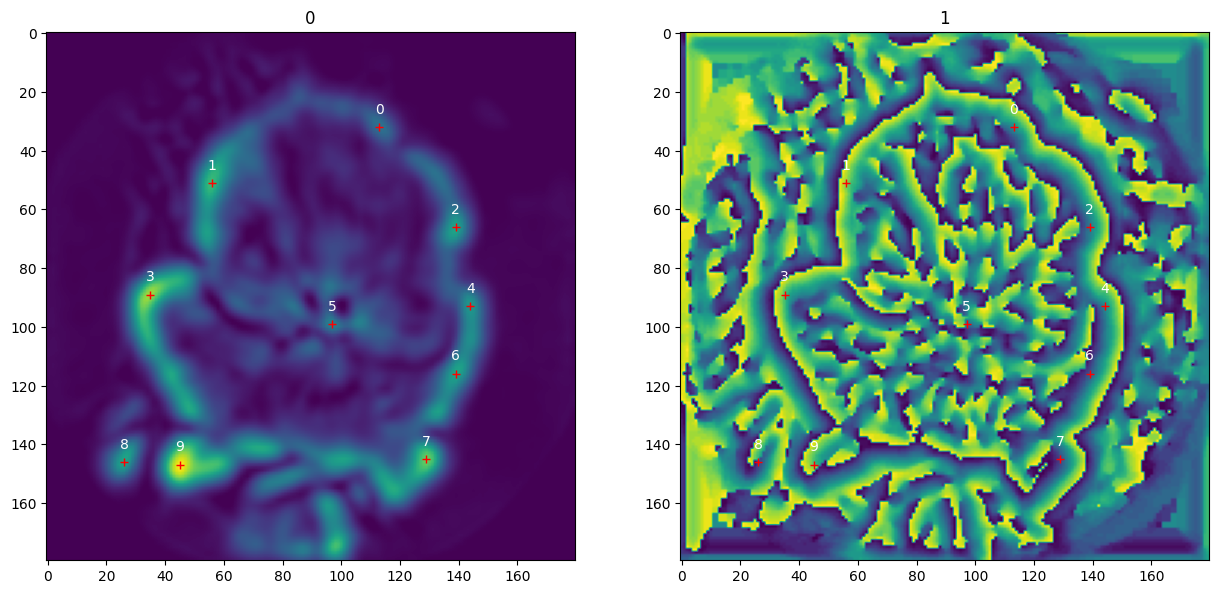

mini_dataloader  torch.Size([9, 2, 31, 31]) torch.Size([1, 9, 2])


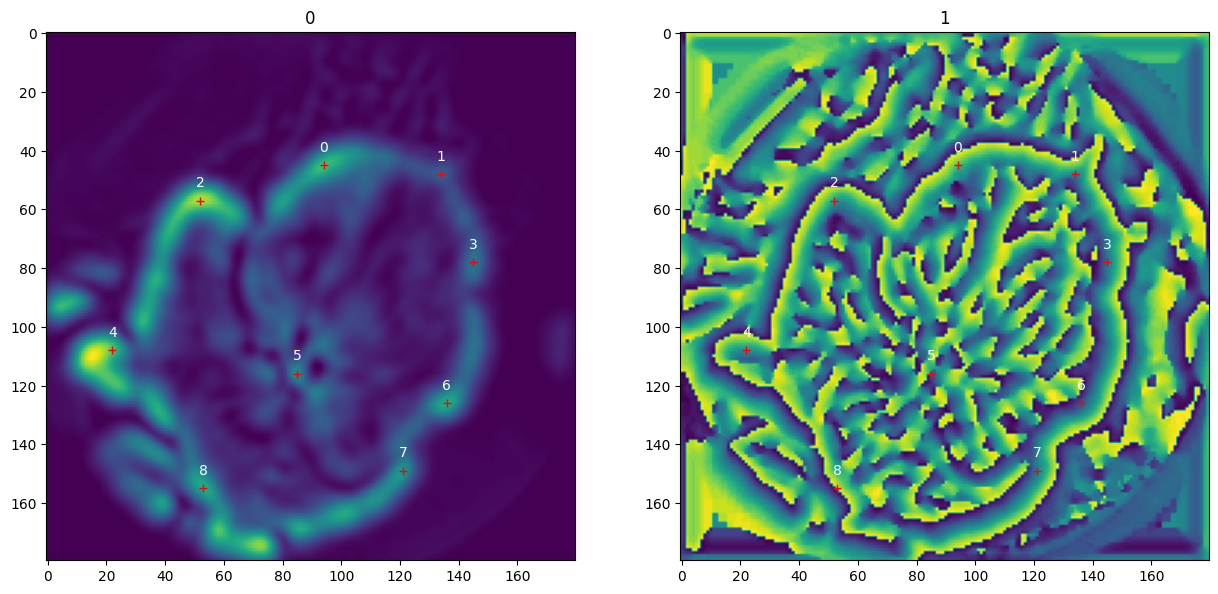

In [499]:
args.nms_size = 30


img_batch, labels =batch
print(len(img_batch),labels) #4

batch_t1 =(img_batch[:1],labels[:1])
img_batch1, labels1 =batch_t1
print(len(img_batch1),labels1) #1

#rotaciona batch_t1
img_batch2 = random_transform(img_batch1)
batch_t2 = (img_batch2,labels1)

plot_pair_image(img_batch1[0,0],img_batch2[0,0],'batch_t1','batch_t2')

#find single point of batch_t2 and batch_t1
feature_t1,orien_t1 = predict_single_points(single_point_model,batch_t1)
batch_result_t1,coords_t1 = extract_features_with_box(feature_t1,orien_t1)
mini_dataloader_t1 = concatenate_mini_batches_feat_orien(batch_result_t1)
points_t1 = coords_t1[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t1.shape,coords_t1.shape)

imshow2(feature_t1[0,0].cpu().detach(),orien_t1[0,0].cpu().detach(),coords_t1[0,:,:17])

feature_t2,orien_t2 = predict_single_points(single_point_model,batch_t2)
batch_result_t2,coords_t2 = extract_features_with_box(feature_t2,orien_t2)
mini_dataloader_t2 = concatenate_mini_batches_feat_orien(batch_result_t2)
points_t2 = coords_t2[:, :2].transpose(1, 2)
print('mini_dataloader ',mini_dataloader_t2.shape,points_t2.shape)
imshow2(feature_t2[0,0].cpu().detach(),orien_t2[0,0].cpu().detach(),coords_t2[0,:,:17])

[(0, 4), (1, 5), (2, 4), (3, 1), (4, 4), (5, 5), (6, 0), (7, 2), (8, 5)]
matching pair  (9, 2)


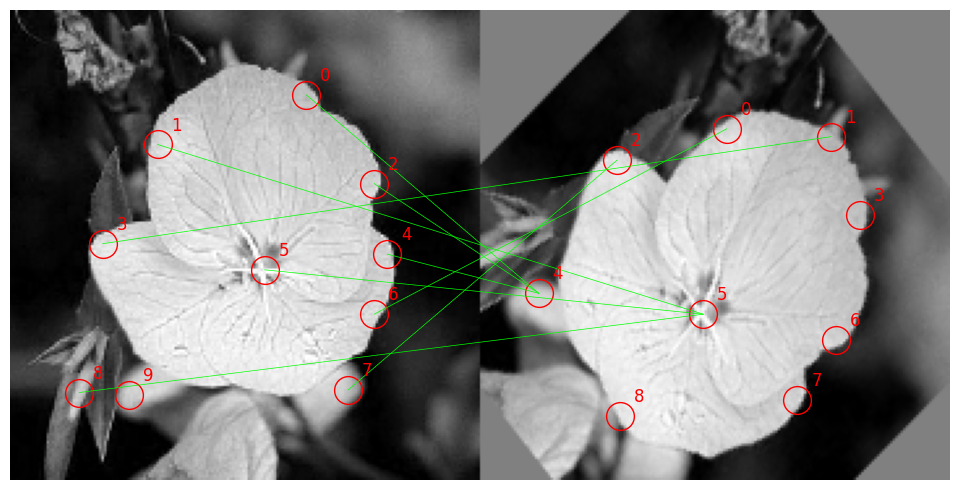

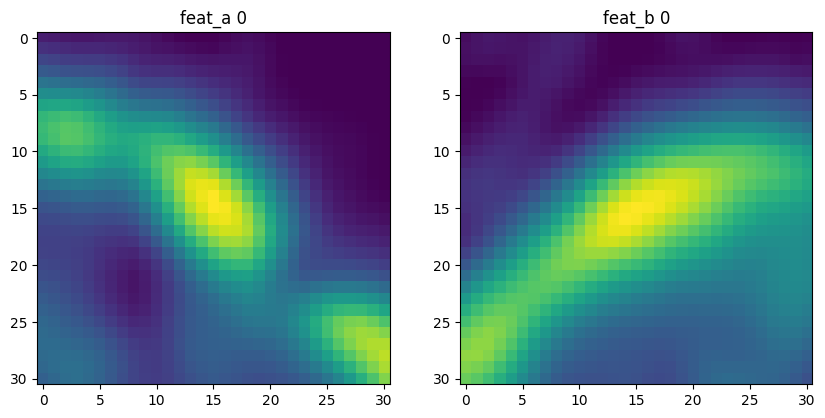

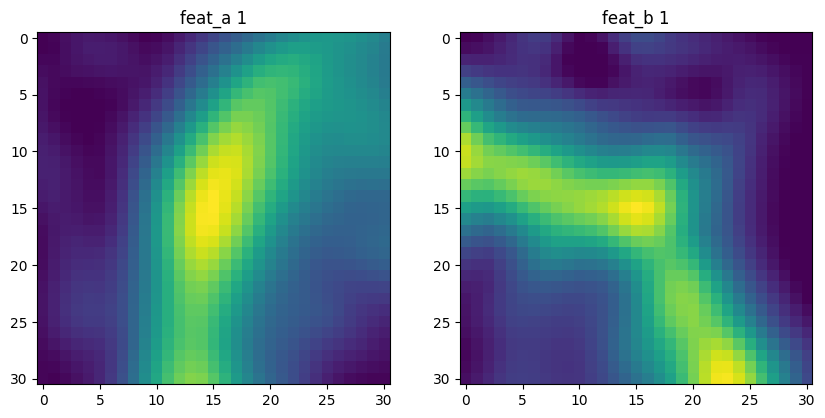

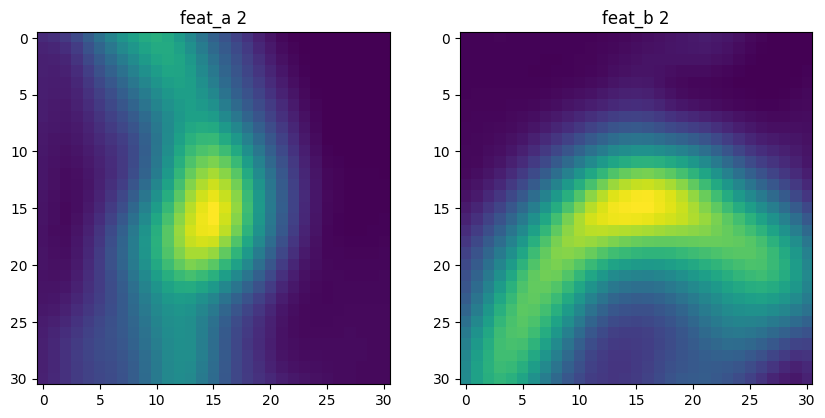

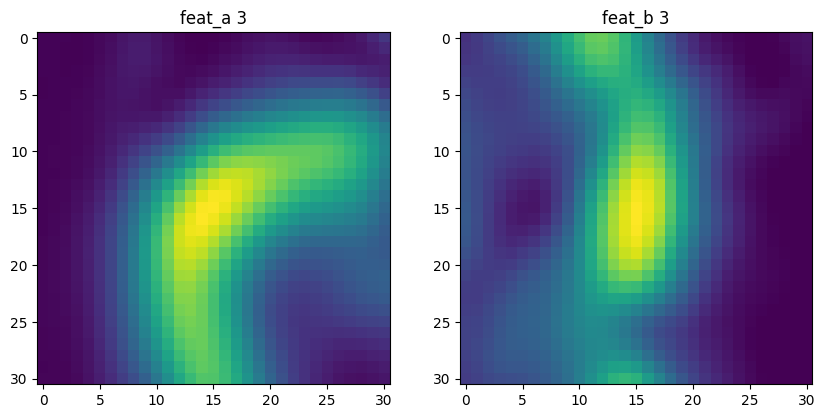

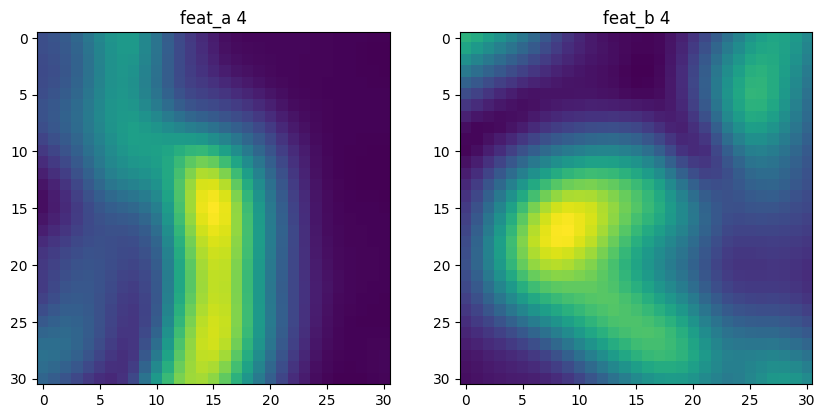

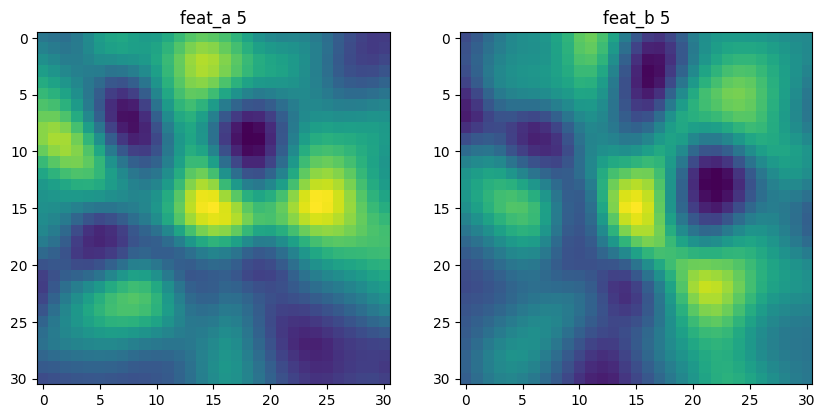

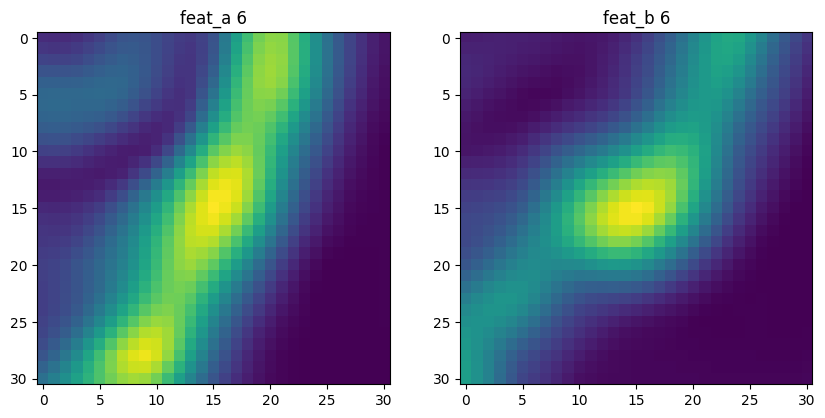

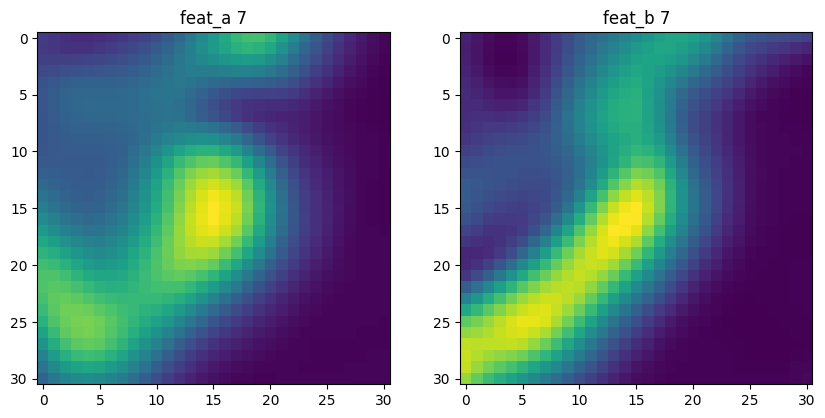

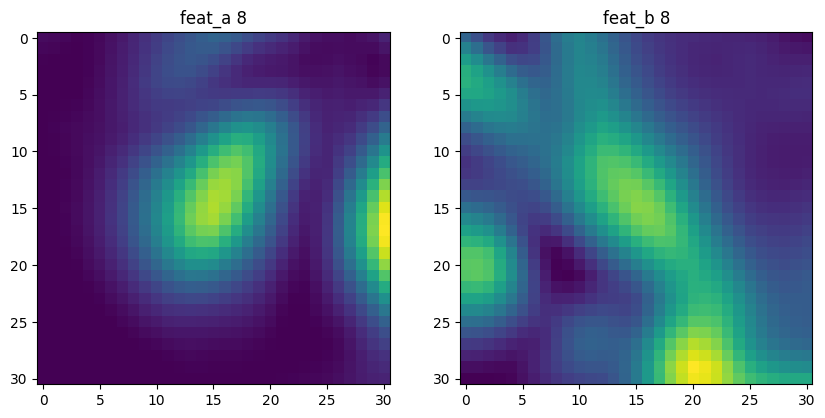

IndexError: index 9 is out of bounds for dimension 0 with size 9

In [500]:



matching_results = matching_single_points(mini_dataloader_t1, mini_dataloader_t2, apply_random_transform=False)

print('matching pair ',matching_results.shape)

plot_matches_keypoints(img_batch1[0,0], points_t1[0],img_batch2[0,0], points_t2[0], matching_results[:10])
for i in range(mini_dataloader_t1.shape[0]):
    plot_pair_image(mini_dataloader_t1[i,0],mini_dataloader_t2[i,0],'feat_a {}'.format(i),'feat_b {}'.format(i))

In [497]:
import torch
import kornia.augmentation as K


# Criando uma sequência de transformações
transformations = K.AugmentationSequential(
    K.RandomAffine(degrees=90, translate=(0.1, 0.1), scale=(0.95, 1.05), shear=10),
    data_keys = ['input', 'keypoints']  # Especificando as chaves de dados
)
# Criando uma imagem de exemplo e coordenadas correspondentes
input_image = img_batch1
keypoints = torch.tensor([[[40, 50], [95, 100], [130, 130]]], dtype=torch.float32)


# Aplicando o aumento de dados nas imagens e coordenadas
augmented_image,augmented_keypoints = transformations(input_image, keypoints)

print(keypoints.shape,augmented_keypoints.shape)
print(keypoints,augmented_keypoints)
# Fazer array de matches entre arrays de coordenadas e coordenadas aumentadas
matching_results =[[i, i] for i in range(keypoints.shape[1])]


torch.Size([1, 3, 2]) torch.Size([1, 3, 2])
tensor([[[ 40.,  50.],
         [ 95., 100.],
         [130., 130.]]]) tensor([[[ 24.9654, 119.4221],
         [ 95.2858,  99.4400],
         [138.4756,  85.6132]]])


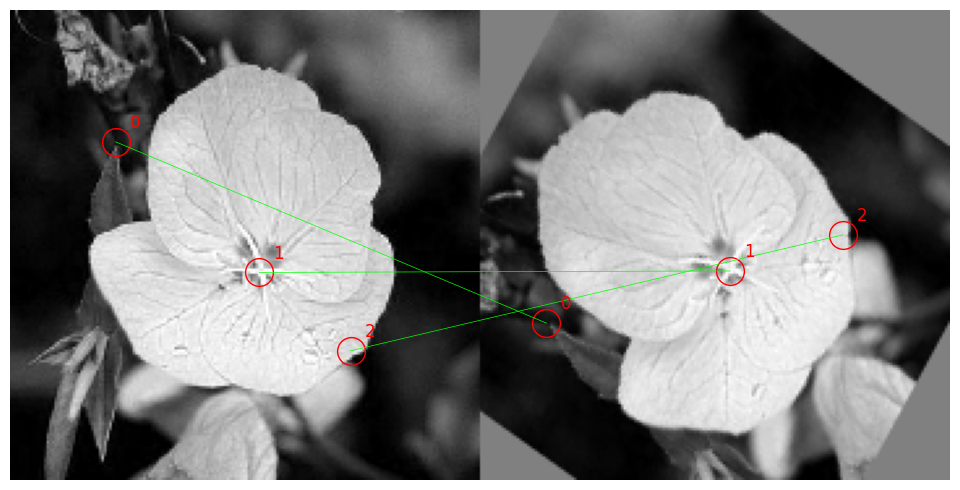

In [498]:


plot_matches_keypoints(input_image[0,0], keypoints[0], augmented_image[0,0], augmented_keypoints[0], matching_results[:10])